# Bag of Visual Words Image Classification: Week 2
## Team 4: 
- Òscar Lorente Corominas
- Ian Riera Smolinska
- Aditya Sangram Singh Rana

## Table of contents
* [1. Dataset](#dataset) 
* [2. Previous work](#intro)
* [3. Dense SIFT](#dense)
* [4. Normalization](#normalization)
* [5. Spatial pyramids](#spatial_pyramids)
    * [5.1 Square sub-regions](#square)
    * [5.2 Horizontal sub-regions](#horizontal)
* [6. Clustering](#clustering)
* [7. Reducing dimensionality with PCA](#pca)
* [8. Classifier: SVM](#classifiers)
* [9. Test validation](#test_validation)
* [10. Fisher Vectors](#fisher)
* [11. Results visualization](#visualization)
    * [11.1 Confusion Matrix and ROC curve](#roc_curve)
    * [11.2 Visualizing matches and missclassifications](#visualizing_matches)

First step is to install the required libraries.

In [ ]:
!pip install opencv-contrib-python==3.4.2.17
!pip install scikit-image
!pip install pandas
!pip install requests
!pip install seaborn

You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


We have to import the libraries that we will be using in the notebook.

In [ ]:
import cv2
import numpy as np
import pickle as cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import cross_validate
from sklearn.metrics import *
from sklearn.preprocessing import LabelBinarizer

from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle

from sklearn.linear_model import LogisticRegression
# grid search part
from sklearn.model_selection import GridSearchCV
import pandas as pd # library for data analsysis
import requests # library to handle requests

from PIL import Image

from skimage.feature import daisy
import matplotlib.pyplot as plt

import seaborn as sns

# Week 2
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.preprocessing import normalize
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
import random

## 1. Dataset <a name="dataset"></a>

Let us first read the train and test files

In [ ]:
train_images_filenames = cPickle.load(open('../week1/train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('../week1/test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('../week1/train_labels.dat','rb'))
test_labels = cPickle.load(open('../week1/test_labels.dat','rb'))

Let's write some simple scripts to visualize the dataset

In [ ]:
class Dataset():
    def __init__(self, images_filenames, labels):
        self.data = images_filenames
        self.labels = labels
    
    def visualize(self, samples_per_class=5):
        print(f'Total number of training samples: {len(self.data)}')
        # get unique classses
        classes = np.unique(np.array(self.labels))
        num_classes = len(classes)
        #set size for plot
        plt.figure(figsize=(15,8))

        for y, cls in enumerate(classes):
            _idxs = np.flatnonzero(np.array(self.labels) == cls)
            idxs = np.random.choice(_idxs, samples_per_class, replace=False)
            for i, idx in enumerate(idxs):
                plt_idx = i * num_classes + y + 1
                plt.subplot(samples_per_class, num_classes, plt_idx)
                plt.imshow(Image.open(self.data[idx]))
                plt.axis('off')
                if i == 0:
                    plt.title(f'{cls} ({len(_idxs)})')
        plt.show()
        
    def show_sample(self, indx):
        return Image.open(self.data[indx])


train = Dataset(train_images_filenames, train_labels)
test = Dataset(test_images_filenames, test_labels)

Total number of training samples: 1881


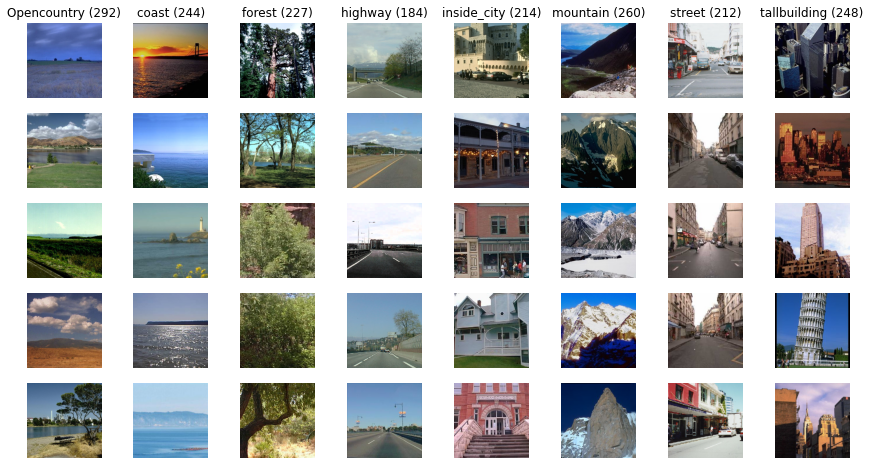

In [ ]:
#for the training dataset
train.visualize()

Total number of training samples: 807


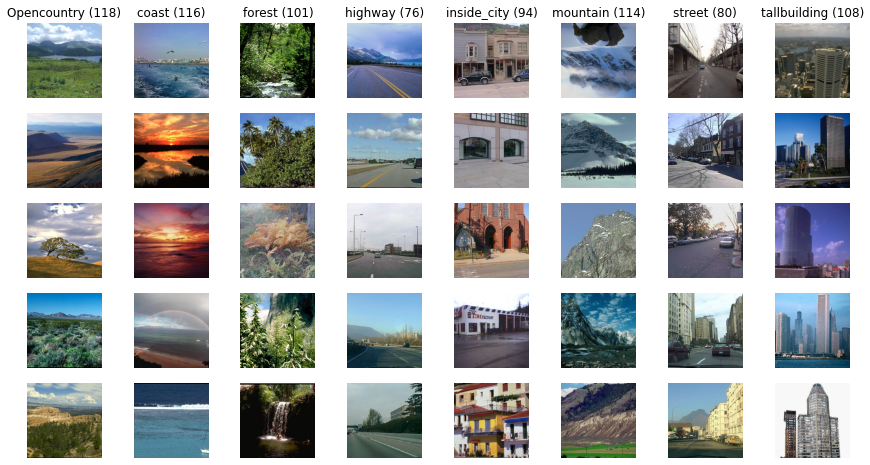

In [ ]:
#for the testing dataset
test.visualize()

## 2. Previous work <a name="intro"></a>

- The best results were obtained using dense SIFT, so that's the descriptor we'll be using this week. However, as we'll
explain later, the algorithm used to create dense keypoints has been adapted to study the important of the scale of 
the keypoints. Here, we want to emulate the property of scale-covariance of the vanilla SIFT descriptor.

- The classifier that will be used this week is the Support Vector Classifier. We won't do any test with K-Nearest 
Neighbors nor logistic regression, as SVM works better (we'll see it later). Check week1 notebook for details
on K-NN and logistic regression results.

- We also implemented spatial pyramids in previous week, but as this specific dataset is formed by a large number of landscape
images, we thought it might be interesting to try dividing the image in horizontal sub-regions as well (and not only square).
Therefore, we've tested our classifier for both types (square and horizontal) sub-regions. We've also included 
normalization, which will be explained later.

- Finally, in previous week we evaluated the results by computing the accuracy and average precision, recall and f1-score.
We're using a balanced dataset, so the accuracy metric is enough to robustly evaluate the classifier. Therefore, to
keep it simple, we'll only compute the cross-validation accuracy to tune the parameters.

To check if the dataset is balanced, we plot the distribution of classes in both the training and test datasets.

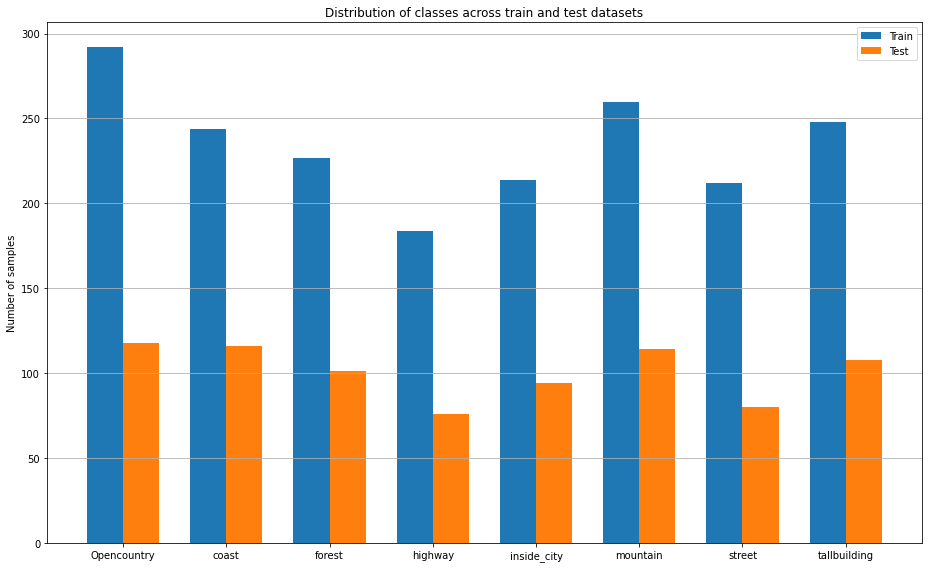

In [ ]:
unique_labels = np.unique(train_labels)
train_count = [np.sum(np.array(train_labels) == label) for label in unique_labels]
test_count = [np.sum(np.array(test_labels) == label) for label in unique_labels]

x = np.arange(len(unique_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
ax.bar(x - width/2, train_count, width, label='Train')
ax.bar(x + width/2, test_count, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of samples')
ax.set_title('Distribution of classes across train and test datasets')
ax.set_xticks(x)
ax.set_xticklabels(unique_labels)
ax.legend()
ax.grid(axis='y')

fig.tight_layout()

plt.show()                    

## 3. Dense SIFT <a name="dense"></a>

Let's start with an utility function to show the dense keypoints

In [ ]:
def show_keypoints(img_path, descriptor=None, kps=None):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    if kps is None:
        kp = descriptor.detect(gray)
    else:
        kp = kps

    kp_img = cv2.drawKeypoints(img, kp, gray)
    fig,axes = plt.subplots(1,2, figsize=(8,4))
    titles = ['Original_image',f'Keypoints:{len(kp)}']
    images = [img, kp_img]
    for ax, image, title in zip(axes.flatten(), images, titles):
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

To implement Dense SIFT, we create a grid of spatially equidistant keypoints. 

In previous week we tuned the parameter "step_size", which defined the distance between keypoints in pixels
(e.g. step_size = 10 -> 10 pixels between each keypoint). This week, we changed the algorithm so that the distance 
between keypoints is adapted to the size of the image.

Now, the distance between each keypoint is configured with the "step_div_size" parameter. To compute this distance we
divide the image size by the "step_div_size" factor. For example, for an image of size 200x200 and a step_div_size=20, 
we'll create keypoints each 10 pixels (horizontally and vertically).

On the other hand, notice that **dense SIFT is not invariant to scale**. Vanilla SIFT is scale-covariant, as it computes 
keypoints at different scales, so we tried to emulate this for dense SIFT with a new parameter: "num_sizes". 
If num_sizes=3, for each size (1,2 and 3), the algorithm creates half of the keypoints but doubling the size of 
the keypoint.

In [ ]:
# To create dense keypoints
def create_dense_kp(img_shape, step_div_size=50, num_sizes=1):
    keypoints = []
    init_step_size_x = max(img_shape[1] // step_div_size, 8)
    init_step_size_y = max(img_shape[0] // step_div_size, 8)
    for i in range(1, num_sizes+1):
        current_step_size_x = init_step_size_x * i
        current_step_size_y = init_step_size_y * i
        kp_size = (current_step_size_x + current_step_size_y) // 2
        keypoints += [cv2.KeyPoint(x, y, kp_size) for y in range(0, img_shape[0], current_step_size_y) 
                                                  for x in range(0, img_shape[1], current_step_size_x)]
    return keypoints

# let's sample an image
sample = train_images_filenames[15]
img=cv2.imread(sample)
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# To compute dense SIFT
SIFTdetector = cv2.xfeatures2d.SIFT_create()
dense_kp = create_dense_kp(gray.shape, step_div_size=10, num_sizes=1)                              
_,dense_sift_des = SIFTdetector.compute(gray, dense_kp)

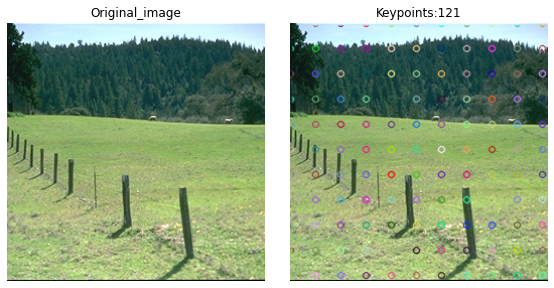

In [ ]:
# Show dense keypoints
show_keypoints(sample, kps=dense_kp)

#### Finding the best step_div_size and num_sizes parameters

As aforementioned, in previous week we tunned the parameter "step_size" and we obtained the best results with a 
value of 15. Here, we're using different parameters to create dense keypoints (and we're also using another classifier: SVM), so 
we wanted to tweak them again to find the best combination for our problem. Moreover, in this week's algorithm 
we're also including a scale factor so that the descriptor (dense SIFT) is somehow scale-covariant. For this 
reason, we want to study the importance of this scale factor for each of the values of "step_div_size".

First of all, we fix a num_sizes = 1 (so we don't take scale into account) and try with different step_div_sizes. We 
compute the accuracy with 8 (stratified) fold cross-validation.

We're also using codebook size = 128 , SVM classifier with RBF kernel and no normalization nor pyramids are applied.

<AxesSubplot:title={'center':'Cross-validation accuracy, num_sizes=1'}, xlabel='Step_div_size', ylabel='Accuracy'>

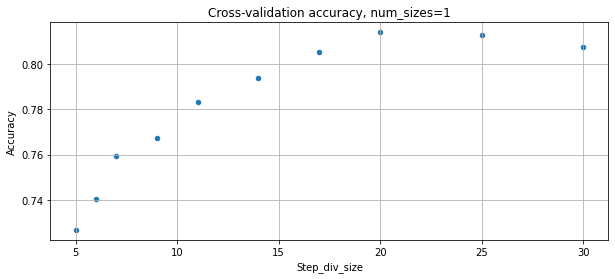

In [ ]:
dense_sift_gridsearch = pd.read_csv('./Optimize_params_w2/dense_sift_params.csv')
dense_sift_gridsearch_fixed_sizes = dense_sift_gridsearch.loc[dense_sift_gridsearch['Num_sizes'] == 1]
dense_sift_gridsearch_fixed_sizes.plot.scatter(x='Step_div_size',y='Accuracy',title='Cross-validation accuracy, num_sizes=1',figsize=(10,4), grid=True)  

The best accuracy is obtained with step_div_size = 20, so we can fix this value and try with different number_sizes. 

<AxesSubplot:title={'center':'Cross-validation accuracy, step_div_size = 20'}, xlabel='Num_sizes', ylabel='Accuracy'>

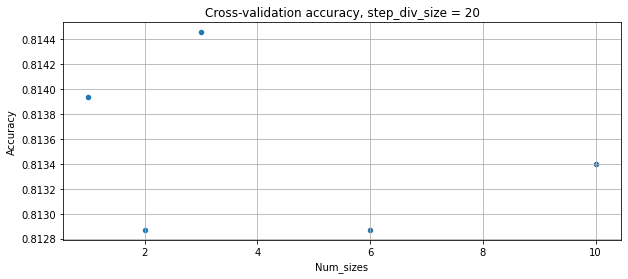

In [ ]:
dense_sift_gridsearch_fixed_step = dense_sift_gridsearch.loc[dense_sift_gridsearch['Step_div_size'] == 20]
dense_sift_gridsearch_fixed_step.plot.scatter(x='Num_sizes',y='Accuracy',title='Cross-validation accuracy, step_div_size = 20',figsize=(10,4), grid=True)  

As we can see, the number of sizes doesn't really affect the results, as we're obtaining a similar accuracy (around 0.81)
for each number of sizes with a fixed step_size_div of 20. This means that the scale is not an important factor in our
specific dataset. However, both parameters (the distance between keypoints and the scale of the keypoints) depend on 
each other, so maybe the results will improve using a different number of sizes for another step_div_size.

For this reason, we used gridsearch to try the following combinations of parameters:

- Step_div_size: 5, 6, 7, 9, 11, 14, 17, 20, 25, 30.
- Num_sizes: 1, 2, 3, 6, 10.

A step_div_size of 5 means that keypoints are computed every 256/5 ~ 50 pixels, and with a step_div_size of 30 
they are computed every 256/50 ~ 8 pixels. We think that this was a good range of values to test our algorithm.

In [ ]:
cm = sns.light_palette("seagreen", as_cmap=True)

s = pd.pivot_table(dense_sift_gridsearch, values='Accuracy', index=['Step_div_size'], 
                   columns=['Num_sizes']).style.set_precision(3)
s.set_caption("Cross-validation accuracy")                   
s.background_gradient(cmap=cm)

#### Conclusions
- The **step_div_size** is the parameter used to define the distance between the dense keypoints. The larger this value,
the smaller the distance between keypoints, and higher the number of keypoints created. For this reason, the resulting accuracy
will improve (up to a certain maximum: 0.814) as we increase the step_div_size (check table above). 

- We can observe that when increasing the step_div_size from 5 to 11, there is an improvement of 5% in accuracy. 
On the other hand, from 17 the accuracy does not increase too much even if we double the size. Therefore we can consider
that the curve has stabilized and we stop increasing the size.

- We don't observe a substantial improvement in the results using different **num_sizes**, so the scale is not an important 
factor in this dataset. For this reason, we can conclude that losing the scale-covariance property of vanilla
 SIFT is not a big deal when using dense SIFT.

- Even if the best accuracy (0.829) is obtained with step_div_size = 30 and num_sizes = 2, this is much more expensive 
computationally than just using a smaller step_div_size. ** For this reason, we'll be using step_div_size = 20 and num_sizes = 1**.


## 4. Normalization <a name="normalization"></a>

It's a good practice to normalize the data to avoid different scales of the feature vectors and thus improve data integrity.
In this case, we're normalizing the histograms of visual words using L2 norm, Power norm or StandardScaler:

- L2 norm -> the modulus of the feature vector is 1:
$$
x_{\text {norm }}=\frac{x}{\|x\|_{2}} 
$$

$$
\|x\|_{2}=\sqrt{x_{1}^{2}+x_{2}^{2}+x_{3}^{2}+\ldots+x_{m}^{2}}
$$

- Power norm -> the sum of all the values of the feature vector is 1:
$$
x_{\text {norm }}=\frac{x}{\sum_{i=1}(x_{i})} 
$$


- StandardScaler -> standardize the feature vector by removing the mean and scaling to unit variance:
$$
x_{\text {norm }}=\frac{x-\mu}{\sigma} ; \quad \mu: mean, \sigma: std
$$


In [ ]:
# to normalize the histogram of visual words
def normalize_visual_words(X,norm='scaler'):
    
    if norm == 'l2':
        return normalize(X, norm='l2')

    elif norm == 'power':
        return X/np.sum([X],axis=-1).reshape(X.shape[0],-1)
        
    elif norm == 'scaler':
        return StandardScaler().fit_transform(X)

#### Normalizing the histogram of visual words
The normalization is very important in spatial pyramids, as we'll comment later. For this reason, we'll try the 
different normalizations in Section [5. Spatial Pyramids](#spatial_pyramids).

## 5. Spatial Pyramids <a name="spatial_pyramids"></a>

The Bag of Visual Words efficiently aggregates local features into a single global vector but it completely ignores the information about 
the spatial layout of the features.

To tackle this, we compute the keypoints and descriptors at different pyramidal levels. Spatial pyramids work by partitioning the image 
into increasingly fine sub-regions and computing histograms of the codewords inside each sub-region.

By computing the descriptors of the different sub-regions of the image, we can later compute the histograms of 
visual words of each of the regions. The code to compute these spatial pyramid histograms is presented in Section 
[6. Clustering](#clustering).

### 5.1 Square sub-regions <a name="square"></a>

The first approach is to divide each region in 4 square sub-regions for each level:

- 0: we compute descriptors of the whole image
- 1: we divide the image in 4 blocks and compute the descriptors for each of them, and finally concatenate them with the whole image descriptor
- 2: we divide the image in 16 blocks, ...
- ...

In [ ]:
def spatial_pyramid_square(img, descriptor, level=1, step_div_size=20, num_sizes=1, plot=False):

    # create dense keypoints and compute descriptors
    dense_kp = create_dense_kp(img.shape, step_div_size=step_div_size, num_sizes=num_sizes)
    _,des = descriptor.compute(img, dense_kp)

    # for visualization purposes
    if plot:
        fig = plt.figure(figsize=(15,5))
        gs = fig.add_gridspec(4*level, 4+4*level)
        ax = fig.add_subplot(gs[:, :4])
        ax.imshow(img)
        ax.axis('off')

    # list that contains the descriptors of img at different levels,
    # being pyramid_descriptors[0] the descriptors of the whole image
    pyramid_descriptors = [des]

    # pyramid_descriptors[1:4] -> descriptors of the four cells (of size 1/4 of the image size)
    # ...

    for l in range(1,level+1):
        level_factor = 2*l
        cell_h = int(gray.shape[0]/level_factor)
        cell_w = int(gray.shape[1]/level_factor)
        
        dense_kp_cell = create_dense_kp([cell_h,cell_w], step_div_size=step_div_size, num_sizes=num_sizes)
            
        for f_h in range(level_factor):
            shift_h = f_h*cell_h
            for f_w in range(level_factor):
                shift_w = f_w*cell_w
                cell = img[shift_h:shift_h+cell_h, shift_w:shift_w+cell_w]
                _,des = descriptor.compute(cell, dense_kp_cell)
                pyramid_descriptors.append(des)

                # for visualization purposes
                if plot:
                    init_row = f_h*4//l
                    last_row = init_row + 4//l
                    init_col = f_w*4//(2*l) + 4*l
                    last_col = init_col + 4//(2*l)
                    ax = fig.add_subplot(gs[init_row:last_row, init_col:last_col])
                    ax.imshow(img[shift_h:shift_h+cell_h, shift_w:shift_w+cell_w])
                    ax.axis('off')


    return pyramid_descriptors

Let's visualize the square blocks created with a spatial pyramid level = 2

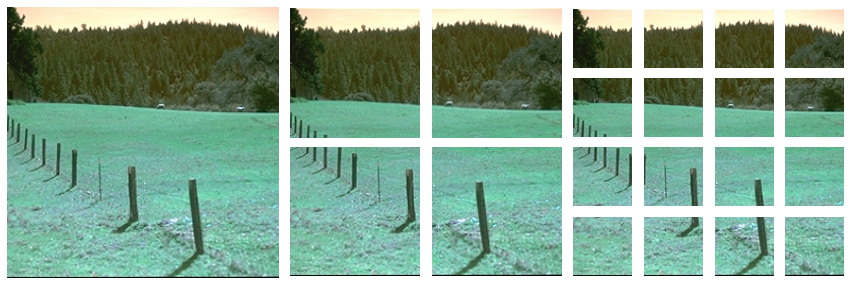

In [ ]:
img_blocks = spatial_pyramid_square(img, SIFTdetector, level=2, plot=True)

#### Tuning spatial pyramid level (square sub-regions) and normalization

The normalization of the histograms of visual words play an important role in the spatial pyramid algorithm. 
If we divide the image in 4 blocks, we will have 1/4 of the information of the whole image for each block. 
Therefore, when computing the histogram of a block, the energy (and thus the contribution) of that histogram will 
be 1/4 of the energy of the histogram of the whole image. To give the same importance to each of them, we can 
normalize all histograms so that they contribute the same.

We compute the accuracy with 8 (stratified) fold cross-validation to tune the parameter "pyramid level" 
for the **square spatial pyramids** and trying different normalizations to see if that
improve the results.

We're testing this with a codebook size = 128 and an SVM classifier with RBF kernel.

In [ ]:
cm = sns.light_palette("seagreen", as_cmap=True)

square_pyramid_gridsearch = pd.read_csv('./Optimize_params_w2/square_pyramid_params.csv')

s = pd.pivot_table(square_pyramid_gridsearch, values='Accuracy', index=['Pyramid level'], 
                   columns=['Norm'])

# For visual purposes, to have None at the first column
cols = s.columns.tolist()
cols = cols[1:2] + cols[0:1] + cols[2:]
s = s[cols]

s = s.style.set_precision(3)
s.set_caption("Cross-validation accuracy")                   
s.background_gradient(cmap=cm)

#### Conclusions

- Comparing the results for the different pyramid levels, we observe that levels 1 and 2 outperform level 0
in all cases, which proves that **spatial information of features is relevant to image classification performance**.

- On the other hand, we observe that level 2 and level 1 only differ by a small margin 
in most of the cases, but level 2 comes with a big extra computational cost (21 vs 5 histograms), so level 1 is chosen 
as the most suitable pyramidal level to use. For higher pyramidal levels, curse of dimensionality also comes into picture 
as our feature space becomes sparse.

- Regarding normalization, we observe that the results are slightly improved in some cases, specially for the L2 norm
and standardScaler. However, the improvement is not significant, which means that the scale of our feature vectors is
consistent.


### 5.2 Horizontal sub-regions <a name="horizontal"></a>
For this specific dataset, formed by a large number of landscapes images, it might be interesting to divide the image 
in horizontal sub-regions, as suggested in the project lecture. Instead of a square grid, we use 3 horizontal rectangles for each level:

- 0: we compute descriptors of the whole image
- 1: we divide the image in 3 horizontal blocks and compute the descriptors for each of them, and finally concatenate them with the whole image descriptor
- 2: we divide the image in 6 horizontal blocks, and do the same...
- ...

In [ ]:
def spatial_pyramid_horizontal(img, descriptor, level=1, step_div_size=20, num_sizes=1, plot=False):

    # create dense keypoints and compute descriptors
    dense_kp = create_dense_kp(img.shape, step_div_size=step_div_size, num_sizes=num_sizes)
    _,des = descriptor.compute(img, dense_kp)

    # list that contains the descriptors of img at different levels,
    # being pyramid_descriptors[0] the descriptors of the whole image
    pyramid_descriptors = [des]

    # for visualization purposes
    if plot:
        fig = plt.figure(figsize=(15,5))
        gs = fig.add_gridspec(3*level, 3+3*level)
        ax = fig.add_subplot(gs[:, :3])
        ax.imshow(img)
        ax.axis('off')
        
    # pyramid_descriptors[1:3] -> descriptors of the four cells (of size 1/3 of the image size)
    # ...
    for l in range(1,level+1):
        level_factor = 3*l
        cell_h = int(gray.shape[0]/level_factor)
        
        dense_kp_cell = create_dense_kp([cell_h,gray.shape[1]], step_div_size=step_div_size, num_sizes=num_sizes)
            
        for f_h in range(level_factor):
            shift_h = f_h*cell_h
            cell = img[shift_h:shift_h+cell_h,:]

            _,des = descriptor.compute(cell, dense_kp_cell)

            pyramid_descriptors.append(des)

            # for visualization purposes
            if plot:
                init_row = f_h*(3*level)//(3*l)
                last_row = init_row + (3*level)//(3*l)
                ax = fig.add_subplot(gs[init_row:last_row, 3*l:3*l+3])
                ax.imshow(img[shift_h:shift_h+cell_h,:])
                ax.axis('off')

    return pyramid_descriptors

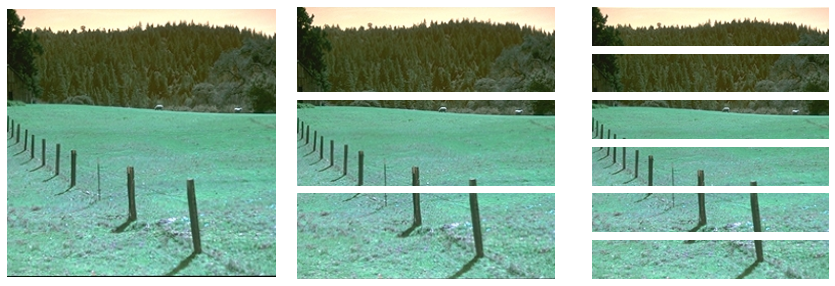

In [ ]:
img_blocks = spatial_pyramid_horizontal(img, SIFTdetector, level=2, plot=True)

#### Tuning spatial pyramid level (horizontal sub-regions) and normalization

Here, we compute the accuracy with 8 (stratified) fold cross-validation to tune the parameter "pyramid level" 
for the **horizontal spatial pyramids** and trying different normalizations to see if that
improve the results.

We're testing this with a codebook size = 128 and an SVM classifier with RBF kernel.

In [ ]:
cm = sns.light_palette("seagreen", as_cmap=True)

horizontal_pyramid_gridsearch = pd.read_csv('./Optimize_params_w2/horizontal_pyramid_params.csv')

s = pd.pivot_table(horizontal_pyramid_gridsearch, values='Accuracy', index=['Pyramid level'], 
                   columns=['Norm'])

# For visual purposes, to have None at the first column
cols = s.columns.tolist()
cols = cols[1:2] + cols[0:1] + cols[2:]
s = s[cols]

s = s.style.set_precision(3)
s.set_caption("Cross-validation accuracy")                   
s.background_gradient(cmap=cm)

#### Conclusions

- For this specific dataset, if we divide the image in horizontal sub-regions, the results are better. The reason is that
most of the images that we're using are landscape images with easily differentiated horizons, as aforementioned.

- Again, we don't see any significant improvements in the results when using normalization, which validates the consistency
and integrity of our data. Even so, it's a good practice to normalize the data, and it will be useful to improve our results later,
so we'll use standardScaler normalization.

**From now on, we'll use Dense SIFT with step_div_size = 20, num_sizes = 1, pyramid level = 1, horizontal sub-regions and with 
standardScaler normalization.**

Now we can compute the training descriptors for our model using our best descriptor so far.

In [ ]:
Train_descriptors = []
Train_label_per_descriptor = []

train_pyramid_descriptors = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima = cv2.imread(filename)
    gray = cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    pyramid_des = spatial_pyramid_horizontal(gray, SIFTdetector, level=1, step_div_size=20, num_sizes=1, plot=False)
    train_pyramid_descriptors.append(pyramid_des)
    Train_descriptors.append(pyramid_des[0])
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

## 6. Clustering <a name="clustering"></a>

We cluster the feature space using k-means, being k the codebook size (number of visual words).



In [ ]:
k = 512
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=10240, compute_labels=False, n_clusters=512,
                random_state=42, reassignment_ratio=0.0001, verbose=False)

#### Tuning codebook size (k)

We already tuned the codebook size in previous week's project, but we want to refine it again to see if we can improve
the results using SVM and spatial pyramids (with normalization). For that reason, we compute the accuracy with 8 (stratified) fold 
cross-validation to tune the parameter codebook size.

We're using an SVM classifier with RBF kernel.

<AxesSubplot:title={'center':'Cross-validation accuracy'}, xlabel='Codebook size', ylabel='Accuracy'>

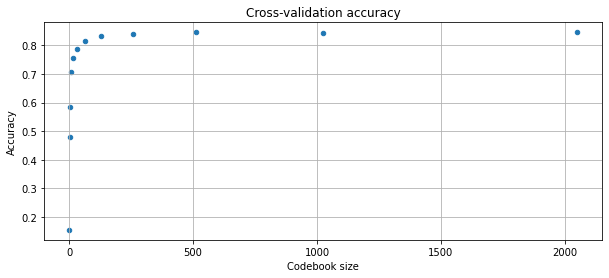

In [ ]:
codebook_size_gridsearch = pd.read_csv('./Optimize_params_w2/codebook_sizes_params.csv')
codebook_size_gridsearch.plot.scatter(x='Codebook size',y='Accuracy',title='Cross-validation accuracy',figsize=(10,4), grid=True)  

#### Conclusions

- With a small codebook size (e.g. 32), the visual words are too general, so they are not representative enough
to perform classification properly.

- With a larger codebook size, the results improve up to a certain point (0.846 for a codebook size of 512). As
expected, when using more visual words, it's easier for the classifier to distinct between the different classes,
because each class is well represented by the corresponding visual words.

- The best results are obtained with a **codebook size of 512**, so that's the one we'll be using from now on. We're
also obtaining really good results with a codebook size of 1024 and 2048, but the computational cost is much higher.

Here we compute the histograms of the sub-regions of the image using the descriptors explained in Section 
[5. Spatial Pyramids](#spatial_pyramids). For each train image, we project each keypoint descriptor to its 
closest visual word. We represent each of the images with the frequency of each visual word through histograms.

In [ ]:
# Compute the pyramid histograms of the descriptors of the image
def spatial_pyramid_histograms(pyramid_descriptor, codebook, k):
    visual_words=np.zeros(k*len(pyramid_descriptor),dtype=np.float32)
    for d in range(len(pyramid_descriptor)):
        # If no keypoints were detected, the frequency of the visual words is 0
        if pyramid_descriptor[d] is None:
            visual_words[d*k:d*k+k]=np.zeros(k)
        else:
            words=codebook.predict(pyramid_descriptor[d])
            visual_words[d*k:d*k+k]=np.bincount(words,minlength=k)
    return visual_words

In [ ]:
visual_words_pyramid=np.zeros((len(train_pyramid_descriptors),k*len(train_pyramid_descriptors[0])),dtype=np.float32)
for i in range(len(train_pyramid_descriptors)):
    visual_words_pyramid[i,:] = spatial_pyramid_histograms(train_pyramid_descriptors[i], codebook, k)

# As aforementioned, it is a good practice to normalize the data
vw_normalized = normalize_visual_words(visual_words_pyramid,'scaler')

## 7. Reducing dimensionality with PCA  <a name="pca"></a>

To decrease computational time, we can use PCA to reduce the feature space dimensionality projecting it to 
a lower dimensional space. In previous week, we studied deeply the performance of the classifiers using PCA and LDA
to reduce the dimensionality of the vector. Here, we'll explore PCA again, as it's useful in this particular case 
where we're using spatial pyramids and the resulting feature vector is much larger.

We use gridsearch to tune the parameter "n_components", which is used to select the number of dimensions to be kept 
after the dimensionality reduction. Notice that we already tuned this parameters in previous 
week's project, but again, we want to refine it to see if we can improve the results using an SVM classifier and 
spatial piramids (with normalization).

In [ ]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(vw_normalized)

classifier = svm.SVC()
classifier.fit(VWpca, train_labels)

SVC()

<AxesSubplot:title={'center':'Cross-validation accuracy'}, xlabel='PCA ncomponents', ylabel='Accuracy'>

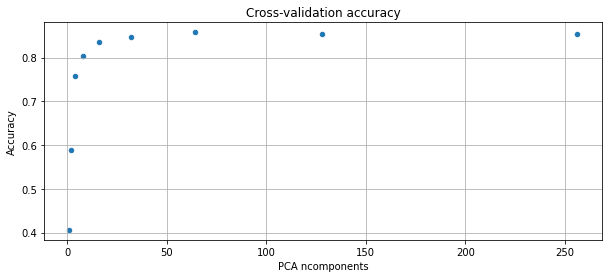

In [ ]:
pca_dim_gridsearch = pd.read_csv('./Optimize_params_w2/pca_ncomponents_params.csv')
pca_dim_gridsearch.plot.scatter(x='PCA ncomponents',y='Accuracy',title='Cross-validation accuracy',figsize=(10,4), grid=True)  

#### Conclusions

- Applying PCA does not increase the performance drastically because we already found the optimal number of features 
using our GridSearch. However, it speeds up the computation as the dimensionality is decreased, while mantaining a similar
performance. For this reason, **we'll use PCA with ncomponents=64**.

- As expected, the best results are obtained with the larger ncomponents (up to a certain point). This parameter
defines the dimensionality of the resulting vector, and the higher its dimension, the more representative
of the data and thus the better the performance of the classifier.

- This reduction of dimensionality is very useful in our case, as spatial pyramids increase the dimension of the vector
and thus the computational time.

## 8. Classifier: SVM <a name="classifiers"></a>

We build an SVM classifier and train it with the train descriptors.

In addition to the kernels used by the sklearn function: ‘linear’, ‘poly’, ‘rbf’, and ‘sigmoid’, we create our own kernel:
the histogram intersection kernel, which is useful for comparisons between histograms. For this reason, it makes sense
to use it in this specific problem. It is defined as:

 $$ K_{i n t}(A, B)=\sum_{i=1}^{m} \min \left\{a_{i}, b_{i}\right\}$$

To decide which is the kernel that works better in our case, we compute the accuracy (mean and standard 
deviation) with 8 (stratified) fold cross-validation.

In [ ]:
# you need to define a callable function to pass the histogram intersection kernel to svm.SVC
def histogramIntersection(data_1, data_2):
    kernel = np.zeros((data_1.shape[0], data_2.shape[0]))

    for d in range(data_1.shape[1]):
        column_1 = data_1[:, d].reshape(-1, 1)
        column_2 = data_2[:, d].reshape(-1, 1)
        kernel += np.minimum(column_1, column_2.T)

    return kernel

In [ ]:
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid',histogramIntersection)}
svc = svm.SVC() 
grid = GridSearchCV(svc, parameters, cv=8)
grid.fit(VWpca, train_labels)

GridSearchCV(cv=8, estimator=SVC(),
             param_grid={'kernel': ('linear', 'poly', 'rbf', 'sigmoid',
                                    <function histogramIntersection at 0x7f1f58f708c0>)})

In [ ]:
svm_kernel_pd = pd.DataFrame.from_dict(grid.cv_results_)
svm_kernel_pd[['param_kernel','mean_test_score','std_test_score','rank_test_score']]

param_kernel  mean_test_score  \
0                                             linear         0.800638   
1                                               poly         0.790013   
2                                                rbf         0.859658   
3                                            sigmoid         0.842109   
4  <function histogramIntersection at 0x7f1f58f70...         0.837863   

   std_test_score  rank_test_score  
0        0.031373                4  
1        0.032834                5  
2        0.023247                1  
3        0.019975                2  
4        0.021336                3

#### Conclusions

- Regarding the linear kernel, we can observe that we're obtaining worse results. 
In our dataset, images of different classes share visual words (e.g. trees in both forests and open country classes), 
therefore our dataset is not linearly separable and it doesn't make sense to use a linear classifier.
- In this case, it is recommended to use the RBF kernel, 
which creates non-linear combinations of the features to uplift the 
samples onto a higher-dimensional feature space where a linear decision boundary can be used. 
And indeed, we obtain the best accuracy with this kernel.
- We can certify that the histogram interesection kernel that we implemented can be used for SVM, as we get good results
using it. This is because this kernel is useful in our specific problem, as we're using histograms as features.
However, it stills performs worse than sigmoid and RBF kernels. For this reason, **we'll use RBF kernel.**




## 9. Test validation <a name="test_validation"></a>
Now that we have trained and cross-validated our system, we can analyze the results that we obtain with the test dataset.

In [ ]:
Test_descriptors = []
visual_words_test=np.zeros((len(test_images_filenames),visual_words_pyramid.shape[1]),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    pyramid_des = spatial_pyramid_horizontal(gray, SIFTdetector, level=1, step_div_size=20, num_sizes=1, plot=False)
    Test_descriptors.append(pyramid_des[0])
    visual_words_test[i,:] = spatial_pyramid_histograms(pyramid_des, codebook, k=512)

vw_test_normalized = normalize_visual_words(visual_words_test,'scaler')

In [ ]:
vwtestpca = pca.transform(vw_test_normalized) 
test_pca_accuracy = classifier.score(vwtestpca, test_labels)

print("%0.2f of test accuracy" % (test_pca_accuracy))


0.87 of test accuracy


#### Conclusions
-  As observed, the performance of the classifier in the test dataset is quite good, and similar to
the one obtained with cross-validation. This means that our **classifier is robust** and it performs well with
data that hasn't been used in the training stage, so **it generalizes well to unseen data**.

- The accuracy (0.87) is much higher than the one obtained previous week (0.78), so we can conclude that **we've improved
and robustified our algorithm**. This is related mainly to the classifier: SVM, which is more powerful than K-NN
or logistic regression (in this specific problem). The spatial pyramids computed with horizontal sub-regions have
also improved the accuracy compared to using square sub-regions. Furthermore, the normalization of the feature vectors
improves the data integrity and thus help in obtaining such good results.

## 10. Optional: Fisher Vectors <a name="fisher"></a>

Even if the BoVW approach performs well on our dataset, it finds the closest word in the 
vocabulary relying only on the number of local descriptors assigned to each Voronoi cell. With **fisher vectors**, 
we're not only using the mean of the local descriptors, but **we're also including higher order statistics**: 
the covariance. This way, we're obtaining the information of how far is each feature from its closest 
vocabulary word (and also to the other vocabulary words). 

As an optional task, we implemented the fisher vectors approach to study its performance in our problem.

We load the precomputed dense SIFT descriptors, computed with step_div_size=20 and num_sizes=1, which gave us the best results.

In [ ]:
def load_pickle(path):
    """
    Retrieve pickle file containing ground truths of query images
    """
    with open(path, 'rb') as f:
        query_gt = cPickle.load(f)
    return query_gt

In [ ]:
Train_descriptors_dense = load_pickle('train_sift_descriptors_dense.pkl')
Test_descriptors_dense = load_pickle('test_sift_descriptors_dense.pkl')

We've used the following function to compute the fisher vectors:

In [ ]:
def fisher_vector(xx, gmm):
    """Computes the Fisher vector on a set of descriptors.
    Parameters
    ----------
    xx: array_like, shape (N, D) or (D, )
        The set of descriptors
    gmm: instance of sklearn mixture.GMM object
        Gauassian mixture model of the descriptors.
    Returns
    -------
    fv: array_like, shape (K + 2 * D * K, )
        Fisher vector (derivatives with respect to the mixing weights, means
        and variances) of the given descriptors.
    Reference
    ---------
    J. Krapac, J. Verbeek, F. Jurie.  Modeling Spatial Layout with Fisher
    Vectors for Image Categorization.  In ICCV, 2011.
    http://hal.inria.fr/docs/00/61/94/03/PDF/final.r1.pdf
    """
    xx = np.atleast_2d(xx)
    N = xx.shape[0]

    # Compute posterior probabilities.
    Q = gmm.predict_proba(xx)  # NxK

    # Compute the sufficient statistics of descriptors.
    Q_sum = np.sum(Q, 0)[:, np.newaxis] / N
    Q_xx = np.dot(Q.T, xx) / N
    Q_xx_2 = np.dot(Q.T, xx ** 2) / N

    # Compute derivatives with respect to mixing weights, means and variances.
    d_pi = Q_sum.squeeze() - gmm.weights_
    d_mu = Q_xx - Q_sum * gmm.means_
    d_sigma = (
        - Q_xx_2
        - Q_sum * gmm.means_ ** 2
        + Q_sum * gmm.covariances_
        + 2 * Q_xx * gmm.means_)

    # Merge derivatives into a vector.
    return np.hstack((d_pi, d_mu.flatten(), d_sigma.flatten()))

And we used the following function to implement the fisher vectors in our algorithm:

In [ ]:
def get_fisher_vectors(num_clusters_gmm, num_components_pca, Train_descriptors, Test_descriptors):
    """
    Returns train and test fisher vectors after training a GMM.

    Parameters
    ----------
        num_clusters_gmm:
            The number of mixture components to use in Gaussian Mixture Model
        num_components_pca:
            Number of components to use while using PCA on SIFT descriptors.
        Train_descriptors:
            List of SIFT descriptors per train image
        Test_descriptors:
            List of SIFT descriptors per test image
    Returns
    -------
    (train_fisher_vectors, test_fisher_vectors)
        Fisher vectors (derivatives with respect to the mixing weights, means
            and variances) for all training and testing samples
    """
    
    # We sample the descriptors to reduce their dimensionality by PCA and computing a GMM. 
    # For a GMM of size k, we need about 1500*k training descriptors
    D=np.vstack(Train_descriptors)
    indices = random.sample(range(0,D.shape[0]),num_clusters_gmm*1500)
    sample = D[indices,:]
    
    #apply PCA on them
    pca = PCA(n_components=num_components_pca)
    samplepca = pca.fit_transform(sample)
    
    # Fit a Gaussian mixture model on them, and compute mean, covariance and weight matrix
    gmm = GaussianMixture(n_components=num_clusters_gmm,covariance_type='diag')
    gmm.fit(samplepca)
    
    # Compute Fisher vectors
    Train_descriptors_fisher = []
    for train_descriptor in tqdm(Train_descriptors):
        start = 0
        length = train_descriptor.shape[0]
        stop = start + length
        train_descriptor_pca = train_descriptor[:,:num_components_pca]
        start = stop
        train_descriptor_fisher = fisher_vector(train_descriptor_pca, gmm)
        Train_descriptors_fisher.append(train_descriptor_fisher)
        
    Dtest = np.vstack(Test_descriptors)
    Test_descriptors_fisher = []
    for test_descriptor in tqdm(Test_descriptors):
        start = 0
        length = test_descriptor.shape[0]
        stop = start + length
        test_descriptor_pca = test_descriptor[:,:num_components_pca]
        start = stop
        test_descriptor_fisher = fisher_vector(test_descriptor_pca, gmm)
        Test_descriptors_fisher.append(test_descriptor_fisher)
    
    # used for normalizing the Fisher Vectors
    def normalize_fisher(descriptors):
        image_fvs = np.vstack(descriptors)
        image_fvs = np.sign(image_fvs) * np.abs(image_fvs) ** 0.5
        norms = np.sqrt(np.sum(image_fvs ** 2, 1))
        image_fvs /= norms.reshape(-1, 1)
        return image_fvs
    
    train_fisher = normalize_fisher(Train_descriptors_fisher)
    test_fisher = normalize_fisher(Test_descriptors_fisher)
    return train_fisher, test_fisher

To study its performance, we fit an SVM classifier with the train fisher vectors (obtained from the training dataset) 
and we use the test fisher vectors to predict the labels of the test dataset.

In [ ]:
# Get Fisher Vectors with num_clusters_GMM = 32 and num_componenets_PCA = 32
train_fisher, test_fisher = get_fisher_vectors(32, 32, Train_descriptors_dense, Test_descriptors_dense)

# Build a SVM Classifier
classifier = svm.SVC()
classifier.fit(train_fisher, train.labels)
accuracy = 100*classifier.score(test_fisher, test.labels)
print(accuracy)

100%|██████████| 807/807 [00:02<00:00, 291.65it/s]
80.42131350681537


We get an accuracy of 0.804 with the above configuration, which is comparable to the results obtained using 
spatial pyramids and Kmeans. To check if this accuracy can be improved, we run a GridSearch to look for the 
optimal number of components to use in PCA and number of clusters to use in Gaussian Mixture Models.

First, we look for the best num_components_PCA while keeping num_clusters_GMM fixed to 16:

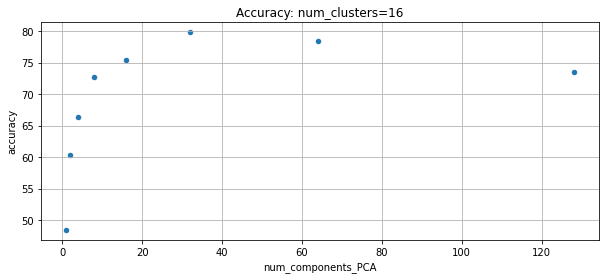

In [ ]:
fv_gridsearch = pd.read_csv('./Optimize_params_w2/fisher_params.csv')
fv_gridsearch = fv_gridsearch.loc[fv_gridsearch['num_clusters_GMM'] == 16]
fv_gridsearch.plot.scatter(x='num_components_PCA',y='accuracy',title='Accuracy: num_clusters=16',figsize=(10,4), grid=True)  
num_comps_pca = [1,2,4,8,16,32,64,128]


After that, we look again for the best num_components_PCA but now keeping num_clusters_GMM fixed to 32:

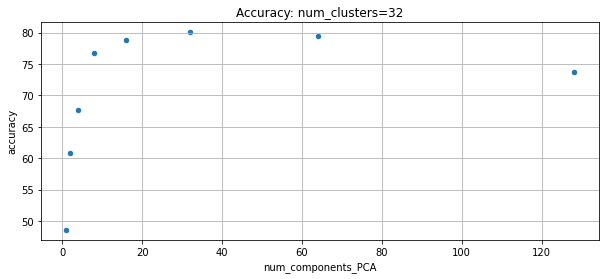

In [ ]:
fv_gridsearch = pd.read_csv('./Optimize_params_w2/fisher_params.csv')
fv_gridsearch = fv_gridsearch.loc[fv_gridsearch['num_clusters_GMM'] == 32]
fv_gridsearch.plot.scatter(x='num_components_PCA',y='accuracy',title='Accuracy: num_clusters=32',figsize=(10,4), grid=True)  
num_comps_pca = [1,2,4,8,16,32,64,128]

In both the cases, **num_components_PCA = 32** was the one with the highest accuracy, so we choose this for our 
further experiments. Then, we look for the best num_clusters_GMM:

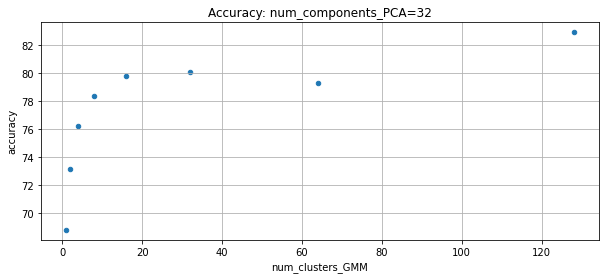

In [ ]:
fv_gridsearch = pd.read_csv('./Optimize_params_w2/fisher_params.csv')
fv_gridsearch = fv_gridsearch.loc[fv_gridsearch['num_components_PCA'] == 32]
fv_gridsearch.plot.scatter(x='num_clusters_GMM',y='accuracy',title='Accuracy: num_components_PCA=32',figsize=(10,4), grid=True)  
num_clusters = [1,2,4,8,16,32,64,128]

The results become a little worse in going from 32 clusters (0.80) to 64 clusters (0.79), but they rise again when 
going to 128 clusters (0.82). We also tried running the code with 256 clusters but scikit's GMM function was not 
able to converge and ended with an error, as GMM complexity grows exponentially when using too many kernels.

We also compare the time taken to train these models for different values of num_clusters_GMM. 

In [ ]:
cm = sns.light_palette("seagreen", as_cmap=True)

fv_gridsearch = pd.read_csv('./Optimize_params_w2/fisher_params.csv')
fv_gridsearch = fv_gridsearch.loc[fv_gridsearch['num_components_PCA'] == 32]
fv_gridsearch.drop(columns='num_components_PCA', inplace=True)
fv_gridsearch.style.set_precision(2).background_gradient(cmap=cm)

#### Conclusions

- Fisher vectors allows training more discriminative classifiers with a lower vocabulary size. Even with 
num_clusters_GMM=2, we get quite good results in just a few seconds. The higher the number of clusters, the higher
the accuracy as well, as GMM is able to model our data with more precision. However, the computational time also
increases.

- The presented results show that encoding our feature vectors using second order information (covariances along with 
means) indeed benefits classification performance, as it provides *similar* results reducing the computational cost. 
For this specific problem, the best results are obtained with a num_components_PCA = 32 and num_clusters_GMM = 128.


## 11. Visualization of Results <a name="visualization"></a>

### 11.1 Confusion Matrix and ROC Curve <a name="roc_curve"></a>


Let's start by plotting the confusion matrix to see the percentage of correct and wrong predictions for each class:

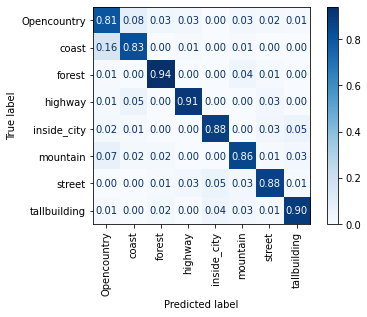

In [ ]:
plot_confusion_matrix(classifier, vwtestpca, test_labels, cmap=plt.cm.Blues,normalize='true',xticks_rotation='vertical',values_format='.2f')  

Additionally, we will plot the ROC curve to visually analyze the behaviour of our classifier when treating it as a one-vs-all binary classifier.

In [ ]:
# first we need to binarize the labels
y_train = LabelBinarizer().fit_transform(train_labels)
y_test = LabelBinarizer().fit_transform(test_labels)
n_classes = y_train.shape[1]
print(y_train)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [ ]:
# classifier
clf = OneVsRestClassifier(svm.SVC())
clf.fit(VWpca, y_train)
y_score = clf.decision_function(vwtestpca)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [ ]:
# Then interpolate all ROC curves 
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  after removing the cwd from sys.path.


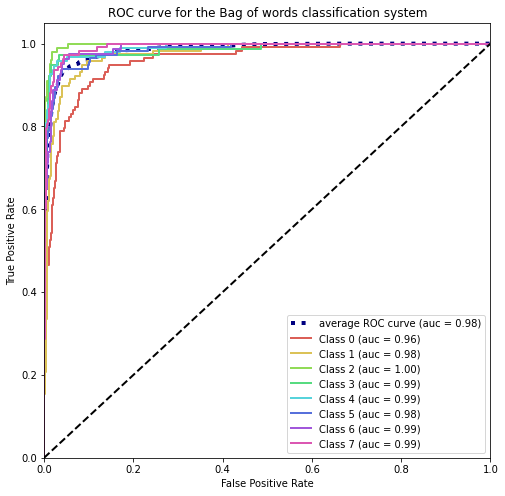

In [ ]:
# Plot all ROC curves
plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr["macro"], tpr["macro"],
         label='average ROC curve (auc = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

palette = sns.color_palette("hls", 8)
colors = cycle(palette)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Class {0} (auc = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the Bag of words classification system')
plt.legend(loc="lower right")
plt.show()

In [ ]:
np.unique(test_labels)

array(['Opencountry', 'coast', 'forest', 'highway', 'inside_city',
       'mountain', 'street', 'tallbuilding'], dtype='<U12')

#### Conclusions
- With the confusion matrix we can validate that most of the predictions are correct, as the percentage of correct
predictions for each class is quite high.
- We can observe (both in the confusion matrix and in the ROC curves) that the class that is best classified is 
class 2, that corresponds to forests. Having a look at the images visualized on [1. Dataset](#dataset), we can 
see how the forest dataset is mainly formed by trees, that have a similar pattern of textures and colors, doesn't 
matter how the forest is.
- On the other hand, the class that is worst classified is class 0, which is Opencountry. The Opencountry dataset shows
different kinds of landscapes, from desert to mountains, in some cases with a big part of the image being the blue sky and others
showing just a bit of clouds, so it can be easily misclassified. This blue sky also explains the high number of
misclassifications between the Opencountry and Coast classes, as it's mistaken with the sea.

### 11.2 Visualizing matches and missclassifications <a name="visualizing_matches"></a>


Finally, we can see the exact predictions that went right and wrong using the following functions.

In [ ]:
def visualize_wrong_predictions(image_filenames, labels, predictions, samples_per_class=5):
    print(f'Number of samples: {len(predictions)}')
    print(f'Number of wrongly classified samples: {sum(predictions!=labels)}')
    
    # get unique classses
    classes = np.unique(np.array(labels))
    num_classes = len(classes)
    #set size for plot
    plt.figure(figsize=(24,16))
    
    def get_index_fp(idxs):
        items = []
        for idx in idxs:
            if predictions[idx] != labels[idx]:
                items.append(idx)
        return items
    
    for y, cls in enumerate(classes):
        idxs_all = np.flatnonzero(np.array(labels) == cls)
        idxs_fp = get_index_fp(idxs_all)
        idxs = np.random.choice(idxs_fp, samples_per_class, replace=False)
        class_accuracy = 100*(1 - (len(idxs_fp)/len(idxs_all)))
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(Image.open(image_filenames[idx]))
            plt.axis('off')
            if i == 0:
                plt.title(f'{cls} \n ClassAccuracy: {class_accuracy:.2f}  \n GT: {test_labels[idx]},\n Pred: {predictions[idx]}')
            else:
                plt.title(f'GT: {test_labels[idx]},\n Pred: {predictions[idx]}')
    plt.show()


def visualize_correct_predictions(image_filenames, labels, predictions, samples_per_class=5):
    print(f'Number of samples: {len(predictions)}')
    print(f'Number of correctly classified samples: {sum(predictions==labels)}')
    
    # get unique classses
    classes = np.unique(np.array(labels))
    num_classes = len(classes)
    #set size for plot
    plt.figure(figsize=(24,16))
    
    def get_index_tp(idxs):
        items = []
        for idx in idxs:
            if predictions[idx] == labels[idx]:
                items.append(idx)
        return items
    
    for y, cls in enumerate(classes):
        idxs_all = np.flatnonzero(np.array(labels) == cls)
        idxs_tp = get_index_tp(idxs_all)
        idxs = np.random.choice(idxs_tp, samples_per_class, replace=False)
        class_accuracy = 100*(len(idxs_tp)/len(idxs_all))
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(Image.open(image_filenames[idx]))
            plt.axis('off')
            if i == 0:
                plt.title(f'ClassAccuracy: {class_accuracy:.2f}  \n GT: {test_labels[idx]},\n Pred: {predictions[idx]}')
            else:
                plt.title(f'GT: {test_labels[idx]},\n Pred: {predictions[idx]}')
    plt.show()

In [ ]:
test_prediction = classifier.predict(vwtestpca)

Number of samples: 807
Number of wrongly classified samples: 104


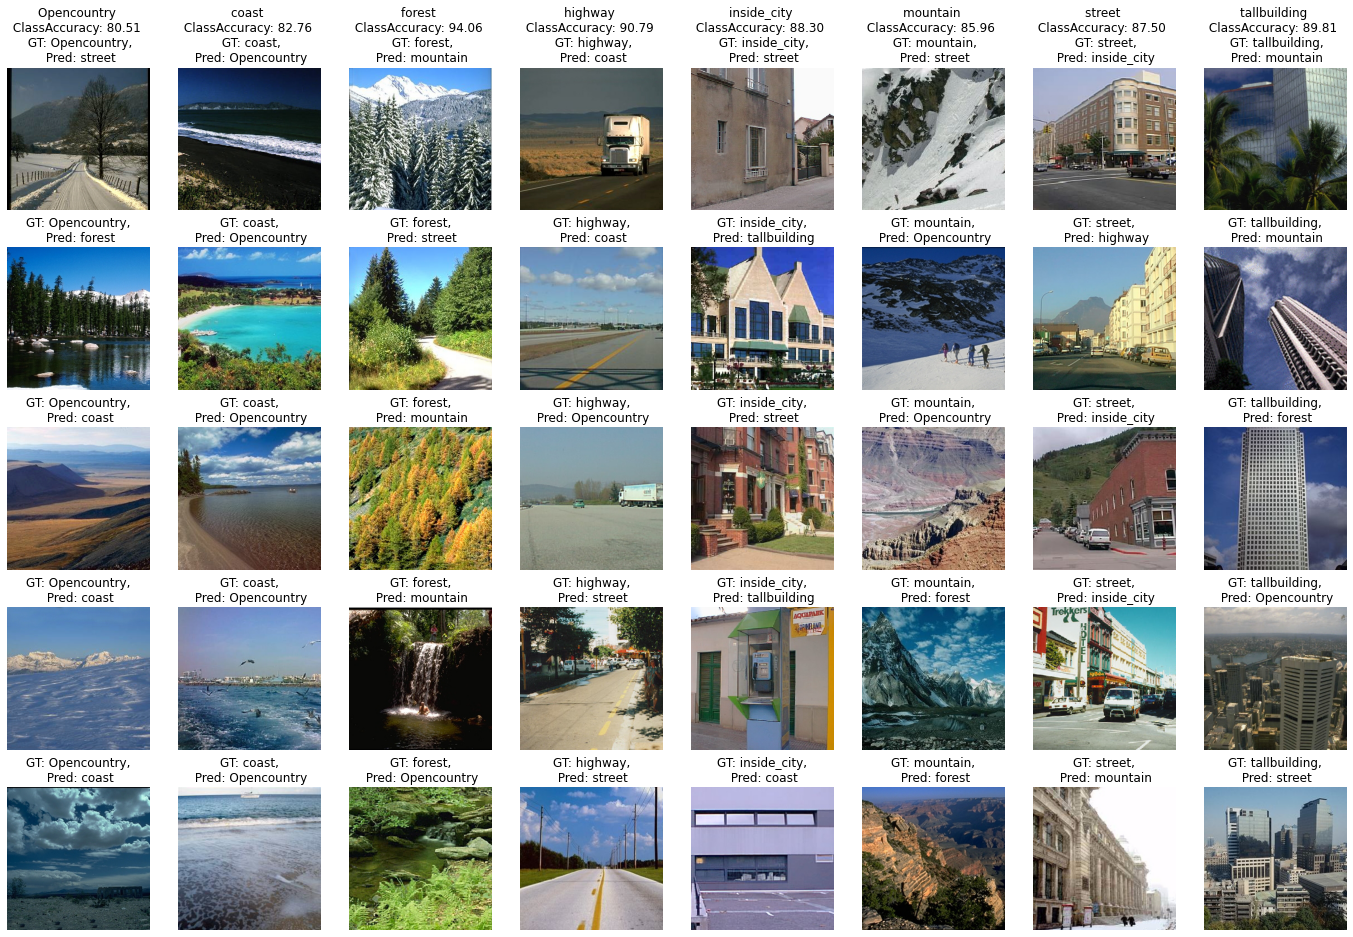

In [ ]:
visualize_wrong_predictions(test_images_filenames, test_labels, test_prediction)

Number of samples: 807
Number of correctly classified samples: 703


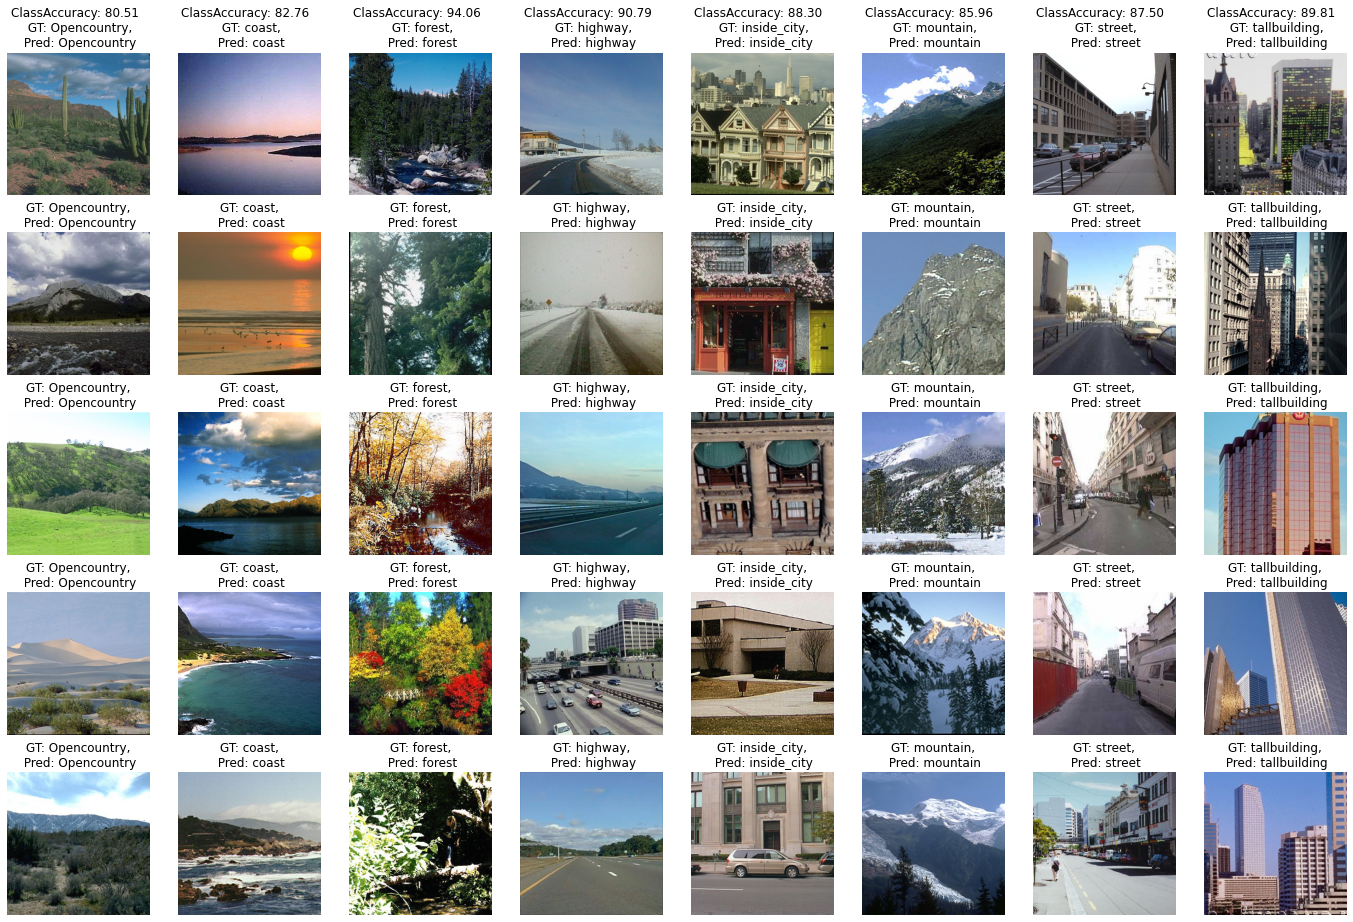

In [ ]:
visualize_correct_predictions(test_images_filenames, test_labels, test_prediction)

## Conclusion

The classes which are difficult to predict for the model are also difficult to predict for humans. As we can see in most of the wrongly 
classified examples, they are wrong because they look very similar to the other classes visually, so it is not a surprise that the model 
has a difficulty in predicting them. The used dataset is tricky as well, as some classes contain other classes as elements. For example, an image of the class inside_city,
might include the view of a street or tall buildings, which are classes themselves.